In [1]:
import os
import ray
import sys; 
sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2
from rag.config import ROOT_DIR
import unstructured

In [31]:
# initiate environment variables
ray.init(runtime_env={
    "env_vars": {
        #"OPENAI_API_BASE": os.environ["OPENAI_API_BASE"],
        "OPENAI_API_KEY": os.environ["OPENAI_API_KEY"] 
        #"ANYSCALE_API_BASE": os.environ["ANYSCALE_API_BASE"],
        #"ANYSCALE_API_KEY": os.environ["ANYSCALE_API_KEY"],
        #"DB_CONNECTION_STRING": os.environ["DB_CONNECTION_STRING"],
    },
    "working_dir": str(ROOT_DIR)
})

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

In [3]:
from pathlib import Path
from rag.config import EFS_DIR, DOCS_DIR
import matplotlib.pyplot as plt
from rag.data import path_to_uri, extract_pages


# Read in data

In [4]:
# Create Ray dataset
ds = ray.data.from_items([{"path": path} for path in DOCS_DIR.rglob("*.pdf") if not path.is_dir()])
print(f"{ds.count()} documents")


4 documents


In [233]:
test_path ='bmj00559-0020.pdf'
path = os.path.join(DOCS_DIR,test_path)

In [5]:
# function to get text data from pdf  - based on
# https://api.python.langchain.com/en/latest/_modules/langchain_community/document_loaders/pdf.html?highlight=PDFMinerPDFasHTMLLoader
# https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf
# https://pdfminersix.readthedocs.io/en/latest/reference/highlevel.html#extract-text-to-fp

from io import StringIO
from pdfminer.high_level import extract_text_to_fp
from pdfminer.layout import LAParams
from pdfminer.utils import open_filename
import re
from bs4 import BeautifulSoup
from langchain_core.documents import Document
from bs4.element import Comment


def get_sections(record, chunk_size=300, chunk_overalp=50):

    # define content length as being 1 in the beginning
    # will be 0 if end of the document is reached and break the loop
    content_length = 1
    # initialize counter
    i=0
    semantic_snippets = []
    page_list = []

    # open file
    with open_filename(record['path'], "rb") as fp:
        # while we still have pages left
        page_id = i+1
        while content_length!=0:
            print(i)
            output_string = StringIO()
            # extract page text and write it as HTML into output_string 
            extract_text_to_fp(
                fp,  # type: ignore[arg-type]
                output_string,
                codec="",
                page_numbers=[i],
                maxpages=1,
                laparams=LAParams(),
                output_type="html",
            )

            # collect metadata
            metadata = {
                "source": record['path'],
                'page': page_id
                }

            # parse html
            soup = BeautifulSoup(output_string.getvalue(),'html.parser')
            content = soup.find_all('div')
            # find different types of styles in the text
            cur_fs = None
            cur_text = ''
            snippets = []   # first collect all snippets that have the same font size
            for c in content:
                sp = c.find('span')
                if not sp:
                    continue
                st = sp.get('style')
                if not st:
                    continue
                fs = re.findall('font-size:(\d+)px',st)
                if not fs:
                    continue
                fs = int(fs[0])
                if not cur_fs:
                    cur_fs = fs
                if fs == cur_fs:
                    cur_text += c.text
                else:
                    snippets.append((cur_text,cur_fs))
                    cur_fs = fs
                    cur_text = c.text
            snippets.append((cur_text,cur_fs))
            i+=1
            # create document object
            data = [Document(page_content=output_string.getvalue(), metadata=metadata)][0]
            content_length = len(snippets[0][0])
            if content_length>0:
                cur_idx = -1
                # Assumption: headings have higher font size than their respective content
                for s in snippets:
                    # if current snippet's font size > previous section's heading => it is a new heading
                    if not semantic_snippets or s[1] > semantic_snippets[cur_idx]['metadata']['heading_font']:
                        metadata={'heading':s[0], 'content_font': 0, 'heading_font': s[1]}
                        metadata.update(data.metadata)
                        #semantic_snippets.append(Document(page_content='',metadata=metadata))
                        semantic_snippets.append({'metadata': metadata, "text": ''})

                        cur_idx += 1
                        continue

                    # if current snippet's font size <= previous section's content => content belongs to the same section (one can also create
                    # a tree like structure for sub sections if needed but that may require some more thinking and may be data specific)
                    if not semantic_snippets[cur_idx]['metadata']['content_font'] or s[1] <= semantic_snippets[cur_idx]['metadata']['content_font']:
                        semantic_snippets[cur_idx]['text'] +=  s[0]
                        semantic_snippets[cur_idx]['metadata']['content_font'] = max(s[1], semantic_snippets[cur_idx]['metadata']['content_font'])
                        #semantic_snippets[cur_idx].page_content += s[0]
                        #semantic_snippets[cur_idx].metadata['content_font'] = max(s[1], semantic_snippets[cur_idx].metadata['content_font'])
                        continue

                    # if current snippet's font size > previous section's content but less than previous section's heading than also make a new
                    # section (e.g. title of a PDF will have the highest font size but we don't want it to subsume all sections)
                    metadata={'heading':s[0], 'content_font': 0, 'heading_font': s[1]}
                    metadata.update(data.metadata)
                    semantic_snippets.append({'metadata': metadata, "text": ''})
                    #semantic_snippets.append(Document(page_content='',metadata=metadata))
                    cur_idx += 1


    return(semantic_snippets)


In [6]:
# Extract pages from papers
sections_ds = ds.flat_map(get_sections)

2023-12-17 22:07:45,638	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(get_sections)]
2023-12-17 22:07:45,640	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)


2023-12-17 22:07:45,641	INFO streaming_executor.py:107 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(FlatMap(get_sections) pid=62796) 0


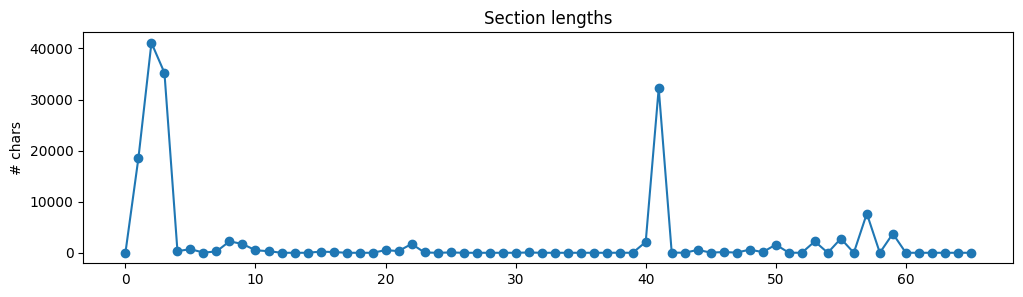

In [7]:
# Plot section lengths
section_lengths = []
for section in sections_ds.take_all():
    section_lengths.append(len(section["text"]))

# Plot
plt.figure(figsize=(12, 3))
plt.plot(section_lengths, marker='o')
plt.title("Section lengths")
plt.ylabel("# chars")
plt.show()

In [8]:

from langchain.text_splitter import RecursiveCharacterTextSplitter
def chunk_section(section, chunk_size=300, chunk_overlap=50):
    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len)
    chunks = text_splitter.create_documents(
        texts=[section['text']], 
        metadatas=[section['metadata']])
    return [{"text": chunk.page_content, "metadata": chunk.metadata} for chunk in chunks]

In [11]:

from functools import partial

# Cut sections into chunks

chunks_ds = sections_ds.flat_map(partial(
    chunk_section))

print(f"{chunks_ds.count()} chunks")


2023-12-17 22:08:31,509	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(get_sections)->FlatMap(partial)]
2023-12-17 22:08:31,510	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-12-17 22:08:31,511	INFO streaming_executor.py:107 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(FlatMap(get_sections)->FlatMap(partial) pid=62796) 0
(FlatMap(get_sections)->FlatMap(partial) pid=62795) 8 [repeated 44x across cluster]
639 chunks


In [12]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import numpy as np
from ray.data import ActorPoolStrategy


In [13]:
def get_embedding_model(embedding_model_name, model_kwargs, encode_kwargs):
    if embedding_model_name == "text-embedding-ada-002":
        embedding_model = OpenAIEmbeddings(
            model=embedding_model_name,
            #openai_api_base=os.environ["OPENAI_API_BASE"],
            openai_api_key=os.environ["OPENAI_API_KEY"])
    else:
        embedding_model = HuggingFaceEmbeddings(
            model_name=embedding_model_name,  # also works with model_path
            model_kwargs=model_kwargs,
            encode_kwargs=encode_kwargs)
    return embedding_model

In [18]:
class EmbedChunks:
    def __init__(self, model_name):
        self.embedding_model = get_embedding_model(
            embedding_model_name=model_name,
            model_kwargs={"device": 0},
            encode_kwargs={"device": 0, "batch_size": 100})
    def __call__(self, batch):
        embeddings = self.embedding_model.embed_documents(batch["text"])
        return {"text": batch["text"], "metadata": batch["metadata"], "embeddings": embeddings}

In [39]:
# Embed chunks
embedding_model_name = "text-embedding-ada-002"
embedded_chunks = chunks_ds.map_batches(
    EmbedChunks,
    fn_constructor_kwargs={"model_name": embedding_model_name},
    batch_size=1, 
    num_gpus=0,
    compute=ActorPoolStrategy(size=1))


In [40]:
embedded_chunks.take(1)

2023-12-20 11:37:25,202	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[FlatMap(get_sections)->FlatMap(partial)->MapBatches(EmbedChunks)] -> LimitOperator[limit=1]
2023-12-20 11:37:25,203	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-12-20 11:37:25,203	INFO streaming_executor.py:107 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-12-20 11:37:25,237	INFO actor_pool_map_operator.py:114 -- FlatMap(get_sections)->FlatMap(partial)->MapBatches(EmbedChunks): Waiting for 1 pool actors to start...


Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(MapWorker(FlatMap(get_sections)->FlatMap(partial)->MapBatches(EmbedChunks)) pid=93413) 0
(MapWorker(FlatMap(get_sections)->FlatMap(partial)->MapBatches(EmbedChunks)) pid=93413) 1
(MapWorker(FlatMap(get_sections)->FlatMap(partial)->MapBatches(EmbedChunks)) pid=93413) 2
(MapWorker(FlatMap(get_sections)->FlatMap(partial)->MapBatches(EmbedChunks)) pid=93413) 3
(MapWorker(FlatMap(get_sections)->FlatMap(partial)->MapBatches(EmbedChunks)) pid=93413) 4
(MapWorker(FlatMap(get_sections)->FlatMap(partial)->MapBatches(EmbedChunks)) pid=93413) 5
(MapWorker(FlatMap(get_sections)->FlatMap(partial)->MapBatches(EmbedChunks)) pid=93413) 6
(MapWorker(FlatMap(get_sections)->FlatMap(partial)->MapBatches(EmbedChunks)) pid=93413) 7
(MapWorker(FlatMap(get_sections)->FlatMap(partial)->MapBatches(EmbedChunks)) pid=93413) 8


In [29]:
import chromadb
from chromadb.utils import embedding_functions


In [32]:
# define embedding function
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                model_name=embedding_model_name,
                api_key=os.environ["OPENAI_API_KEY"] 
            )

In [25]:
#client = chromadb.HttpClient(host='localhost', port=8000)
client = chromadb.PersistentClient(path="/Users/htr365/Documents/Side_Projects/09_founding_lab/semester_project/meta-studies/extraction/chromadb/")
client.heartbeat()

1703068162419370000

In [34]:
collection = client.get_or_create_collection(
        name="paper_collection1",
        metadata={"hnsw:space": "cosine"} ,
        embedding_function= openai_ef
    )

In [ ]:
collection.add(
documents= docs,
metadatas=meta,
ids=ids
)

In [62]:
print ("embedding size:", len(sample[0]["embeddings"]))
print (sample[0]["text"])

embedding size: 1536
cholesterol concentration doesnotcausedepression,
accidents, orsuicide.
AsSherlock Holmes observed, onecanhavetoo
muchevidence: "Whatwasvitalwasoverlaid and
hiddenbywhatwasirrelevant.""5 Therandomised trial
dataarevital,but,giventhetrialevidence, observational


(autoscaler +39m20s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +39m55s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +40m31s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +41m6s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +41m41s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +42m16s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to r

In [63]:
sample[0]

{'text': 'cholesterol concentration doesnotcausedepression,\naccidents, orsuicide.\nAsSherlock Holmes observed, onecanhavetoo\nmuchevidence: "Whatwasvitalwasoverlaid and\nhiddenbywhatwasirrelevant.""5 Therandomised trial\ndataarevital,but,giventhetrialevidence, observational',
 'source': 'https://docs.ray.io/Users/htr365/Documents/Side_Projects/09_founding_lab/semester_project/meta-studies/extraction/papers/original_studies/bmj00559-0020.pdf#0',
 'embeddings': [-0.007997798754145075,
  -0.00016119206016757865,
  0.032739527608384854,
  -0.02603126324010461,
  -0.021714991014860928,
  0.028570247888118915,
  -0.017371993556946803,
  -0.00688866341409604,
  -0.02603126324010461,
  -0.012414293395870647,
  -0.00902007336272486,
  0.02575063898383919,
  -0.00906684438254329,
  0.03001345888109683,
  -0.007937664186668848,
  0.004316272225243681,
  0.060989059665942376,
  -0.0062338728619283435,
  0.014178219288087377,
  -0.019563537141729277,
  -0.0070423386242252604,
  0.02262368059062360

(autoscaler +44m36s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +45m11s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
